### Data 1030 Project

Dataset "Ad Click Prediction" from Kaggle is linked [here](https://www.kaggle.com/datasets/marius2303/ad-click-prediction-dataset). 

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance  

# overview of dataset
df = pd.read_csv('ad_click_dataset.csv')
print(df.head()) 

     id full_name   age      gender device_type ad_position browsing_history  \
0   670   User670  22.0         NaN     Desktop         Top         Shopping   
1  3044  User3044   NaN        Male     Desktop         Top              NaN   
2  5912  User5912  41.0  Non-Binary         NaN        Side        Education   
3  5418  User5418  34.0        Male         NaN         NaN    Entertainment   
4  9452  User9452  39.0  Non-Binary         NaN         NaN     Social Media   

  time_of_day  click  
0   Afternoon      1  
1         NaN      1  
2       Night      1  
3     Evening      1  
4     Morning      0  


In [3]:
print("Number of rows: ", df.shape[0])
print("Number of columns: ", df.shape[1])

Number of rows:  10000
Number of columns:  9


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                10000 non-null  int64  
 1   full_name         10000 non-null  object 
 2   age               5234 non-null   float64
 3   gender            5307 non-null   object 
 4   device_type       8000 non-null   object 
 5   ad_position       8000 non-null   object 
 6   browsing_history  5218 non-null   object 
 7   time_of_day       8000 non-null   object 
 8   click             10000 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 703.3+ KB


In [12]:
count_ones = (df['click'] == 1).sum()
count_zeros = (df['click'] == 0).sum()

print(f"Number of 1's in the 'click' column: {count_ones}")
print(f"Number of 0's in the 'click' column: {count_zeros}")

Number of 1's in the 'click' column: 6500
Number of 0's in the 'click' column: 3500


In [5]:
# number/proportion of missing values

number_na = df['age'].isna().sum()
proportion = 100*number_na/df.shape[0]
print("Number of NA in age:", number_na, ", proportion:", proportion,"%")

number_na1 = df['gender'].isna().sum()
proportion1 = 100*number_na1/df.shape[0]
print("Number of NA in gender:", number_na1, ", proportion:", proportion1,"%")

number_na2 = df['device_type'].isna().sum()
proportion2 = 100*number_na2/df.shape[0]
print("Number of NA in device_type:", number_na2, ", proportion:", proportion2,"%")

number_na3 = df['ad_position'].isna().sum()
proportion3 = 100*number_na3/df.shape[0]
print("Number of NA in ad_position:", number_na3, ", proportion:", proportion3,"%")

number_na4 = df['browsing_history'].isna().sum()
proportion4 = 100*number_na4/df.shape[0]
print("Number of NA in browsing_history:", number_na4, ", proportion:", proportion4,"%")

number_na5 = df['time_of_day'].isna().sum()
proportion5 = 100*number_na5/df.shape[0]
print("Number of NA in time_of_day:", number_na5, ", proportion:", proportion5,"%")

Number of NA in age: 4766 , proportion: 47.66 %
Number of NA in gender: 4693 , proportion: 46.93 %
Number of NA in device_type: 2000 , proportion: 20.0 %
Number of NA in ad_position: 2000 , proportion: 20.0 %
Number of NA in browsing_history: 4782 , proportion: 47.82 %
Number of NA in time_of_day: 2000 , proportion: 20.0 %


In [9]:
# types of data/entries in each feature
unique_counts = df['time_of_day'].nunique()
print(unique_counts)

4


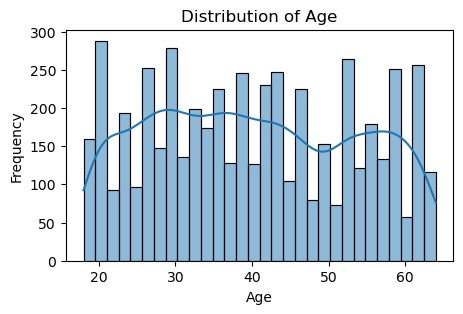

In [7]:
# new plot
plt.figure(figsize=(5,3))
sns.histplot(df['age'], bins=30, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# END OF EDA

In [4]:
# preprocessing

# Fill missing values in categorical data features using 'unknown'
selected_columns = ['device_type', 'ad_position', 'browsing_history', 'time_of_day'] 
df[selected_columns] = df[selected_columns].fillna('unknown')

y = df['click'] 
X = df.loc[:, df.columns != 'click']

onehot_ftrs = ['gender','device_type','ad_position','browsing_history','time_of_day', 'age'] 

# collect all the encoders into one preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), onehot_ftrs)
    ])

prep = Pipeline(steps=[('preprocessor', preprocessor)])

In [24]:
X_train_prep = prep.fit_transform(X_train)
print(X_train_prep)

[[ 0.          0.          1.         ...  0.          0.
  -0.75496409]
 [ 0.          1.          0.         ...  0.          0.
          nan]
 [ 1.          0.          0.         ...  0.          0.
          nan]
 ...
 [ 0.          0.          1.         ...  0.          1.
  -0.90685978]
 [ 0.          1.          0.         ...  1.          0.
  -0.07143346]
 [ 0.          1.          0.         ...  0.          0.
          nan]]


In [11]:
# baseline F1 score
y_true = y = df['click'] 

y_pred_baseline = pd.Series(np.ones(len(y_true)))

f1_base = f1_score(y_true, y_pred_baseline)

print (f1_base)

0.7878787878787878


randoms state 1
    {'gamma': 0.001, 'C': 0.01}
    0.7839481151195784 0.78419452887538
    {'gamma': 0.01, 'C': 0.01}
    0.7839481151195784 0.78419452887538
    {'gamma': 0.1, 'C': 0.01}
    0.7839481151195784 0.78419452887538
    {'gamma': 1, 'C': 0.01}
    0.7839481151195784 0.78419452887538
    {'gamma': 10, 'C': 0.01}
    0.7839481151195784 0.78419452887538
    {'gamma': 0.001, 'C': 0.1}
    0.7839481151195784 0.78419452887538
    {'gamma': 0.01, 'C': 0.1}
    0.7839481151195784 0.78419452887538
    {'gamma': 0.1, 'C': 0.1}
    0.7839481151195784 0.78419452887538
    {'gamma': 1, 'C': 0.1}
    0.7839481151195784 0.78419452887538
    {'gamma': 10, 'C': 0.1}
    0.7839481151195784 0.78419452887538
    {'gamma': 0.001, 'C': 1}
    0.7839481151195784 0.78419452887538
    {'gamma': 0.01, 'C': 1}
    0.7839481151195784 0.78419452887538
    {'gamma': 0.1, 'C': 1}
    0.7987564766839378 0.7839506172839507
    {'gamma': 1, 'C': 1}
    0.9487628092976755 0.7592105263157894
    {'gamma': 10

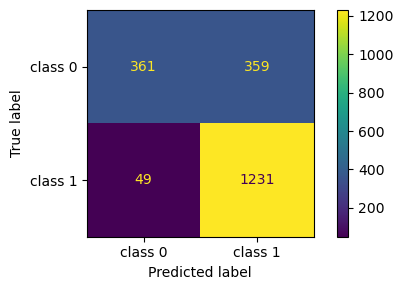

test score: 0.8578397212543554
randoms state 2
    {'gamma': 0.001, 'C': 0.01}
    0.7900786448880823 0.7893462469733656
    {'gamma': 0.01, 'C': 0.01}
    0.7900786448880823 0.7893462469733656
    {'gamma': 0.1, 'C': 0.01}
    0.7900786448880823 0.7893462469733656
    {'gamma': 1, 'C': 0.01}
    0.7900786448880823 0.7893462469733656
    {'gamma': 10, 'C': 0.01}
    0.7900786448880823 0.7893462469733656
    {'gamma': 0.001, 'C': 0.1}
    0.7900786448880823 0.7893462469733656
    {'gamma': 0.01, 'C': 0.1}
    0.7900786448880823 0.7893462469733656
    {'gamma': 0.1, 'C': 0.1}
    0.7900786448880823 0.7893462469733656
    {'gamma': 1, 'C': 0.1}
    0.7900786448880823 0.7893462469733656
    {'gamma': 10, 'C': 0.1}
    0.7900786448880823 0.7893462469733656
    {'gamma': 0.001, 'C': 1}
    0.7900786448880823 0.7893462469733656
    {'gamma': 0.01, 'C': 1}
    0.7900786448880823 0.7893462469733656
    {'gamma': 0.1, 'C': 1}
    0.801970038990355 0.7931456548347613
    {'gamma': 1, 'C': 1}
    

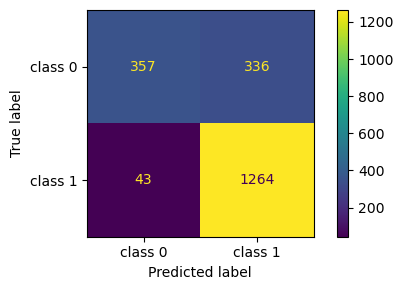

test score: 0.869625042999656
randoms state 3
    {'gamma': 0.001, 'C': 0.01}
    0.7868985038414881 0.7871437234687689
    {'gamma': 0.01, 'C': 0.01}
    0.7868985038414881 0.7871437234687689
    {'gamma': 0.1, 'C': 0.01}
    0.7868985038414881 0.7871437234687689
    {'gamma': 1, 'C': 0.01}
    0.7868985038414881 0.7871437234687689
    {'gamma': 10, 'C': 0.01}
    0.7868985038414881 0.7871437234687689
    {'gamma': 0.001, 'C': 0.1}
    0.7868985038414881 0.7871437234687689
    {'gamma': 0.01, 'C': 0.1}
    0.7868985038414881 0.7871437234687689
    {'gamma': 0.1, 'C': 0.1}
    0.7868985038414881 0.7871437234687689
    {'gamma': 1, 'C': 0.1}
    0.7868985038414881 0.7871437234687689
    {'gamma': 10, 'C': 0.1}
    0.7868985038414881 0.7871437234687689
    {'gamma': 0.001, 'C': 1}
    0.7868985038414881 0.7871437234687689
    {'gamma': 0.01, 'C': 1}
    0.7868985038414881 0.7871437234687689
    {'gamma': 0.1, 'C': 1}
    0.7981859410430839 0.7845303867403315
    {'gamma': 1, 'C': 1}
    

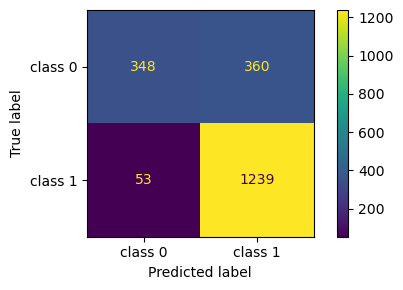

test score: 0.8571428571428571
randoms state 4
    {'gamma': 0.001, 'C': 0.01}
    0.7868985038414881 0.7864077669902912
    {'gamma': 0.01, 'C': 0.01}
    0.7868985038414881 0.7864077669902912
    {'gamma': 0.1, 'C': 0.01}
    0.7868985038414881 0.7864077669902912
    {'gamma': 1, 'C': 0.01}
    0.7868985038414881 0.7864077669902912
    {'gamma': 10, 'C': 0.01}
    0.7868985038414881 0.7864077669902912
    {'gamma': 0.001, 'C': 0.1}
    0.7868985038414881 0.7864077669902912
    {'gamma': 0.01, 'C': 0.1}
    0.7868985038414881 0.7864077669902912
    {'gamma': 0.1, 'C': 0.1}
    0.7868985038414881 0.7864077669902912
    {'gamma': 1, 'C': 0.1}
    0.7868985038414881 0.7864077669902912
    {'gamma': 10, 'C': 0.1}
    0.7868985038414881 0.7864077669902912
    {'gamma': 0.001, 'C': 1}
    0.7868985038414881 0.7864077669902912
    {'gamma': 0.01, 'C': 1}
    0.7868985038414881 0.7864077669902912
    {'gamma': 0.1, 'C': 1}
    0.8029739776951673 0.7938461538461539
    {'gamma': 1, 'C': 1}
   

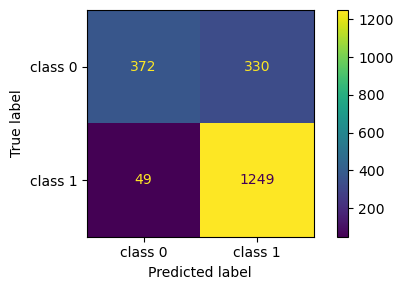

test score: 0.8682655543969413
randoms state 5
    {'gamma': 0.001, 'C': 0.01}
    0.7895904781117612 0.7893462469733656
    {'gamma': 0.01, 'C': 0.01}
    0.7895904781117612 0.7893462469733656
    {'gamma': 0.1, 'C': 0.01}
    0.7895904781117612 0.7893462469733656
    {'gamma': 1, 'C': 0.01}
    0.7895904781117612 0.7893462469733656
    {'gamma': 10, 'C': 0.01}
    0.7895904781117612 0.7893462469733656
    {'gamma': 0.001, 'C': 0.1}
    0.7895904781117612 0.7893462469733656
    {'gamma': 0.01, 'C': 0.1}
    0.7895904781117612 0.7893462469733656
    {'gamma': 0.1, 'C': 0.1}
    0.7895904781117612 0.7893462469733656
    {'gamma': 1, 'C': 0.1}
    0.7895904781117612 0.7893462469733656
    {'gamma': 10, 'C': 0.1}
    0.7895904781117612 0.7893462469733656
    {'gamma': 0.001, 'C': 1}
    0.7895904781117612 0.7893462469733656
    {'gamma': 0.01, 'C': 1}
    0.7895904781117612 0.7893462469733656
    {'gamma': 0.1, 'C': 1}
    0.8042895442359249 0.7972889710412816
    {'gamma': 1, 'C': 1}
   

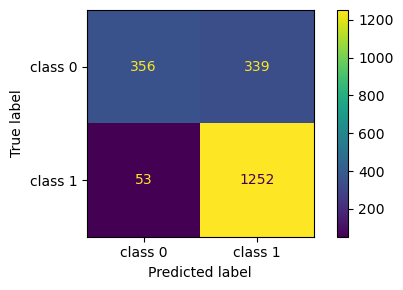

test score: 0.8646408839779005
mean validation score:  0.00874125983116859
mean test score:  0.005176490277358887
validation standard deviation:  0.00874125983116859
test standard deviation:  0.005176490277358887
['gender_Female' 'gender_Male' 'gender_Non-Binary' 'gender_nan'
 'device_type_Desktop' 'device_type_Mobile' 'device_type_Tablet'
 'device_type_unknown' 'ad_position_Bottom' 'ad_position_Side'
 'ad_position_Top' 'ad_position_unknown' 'browsing_history_Education'
 'browsing_history_Entertainment' 'browsing_history_News'
 'browsing_history_Shopping' 'browsing_history_Social Media'
 'browsing_history_unknown' 'time_of_day_Afternoon' 'time_of_day_Evening'
 'time_of_day_Morning' 'time_of_day_Night' 'time_of_day_unknown'
 'age_18.0' 'age_19.0' 'age_20.0' 'age_21.0' 'age_22.0' 'age_23.0'
 'age_24.0' 'age_25.0' 'age_26.0' 'age_27.0' 'age_28.0' 'age_29.0'
 'age_30.0' 'age_31.0' 'age_32.0' 'age_33.0' 'age_34.0' 'age_35.0'
 'age_36.0' 'age_37.0' 'age_38.0' 'age_39.0' 'age_40.0' 'age_41.0'

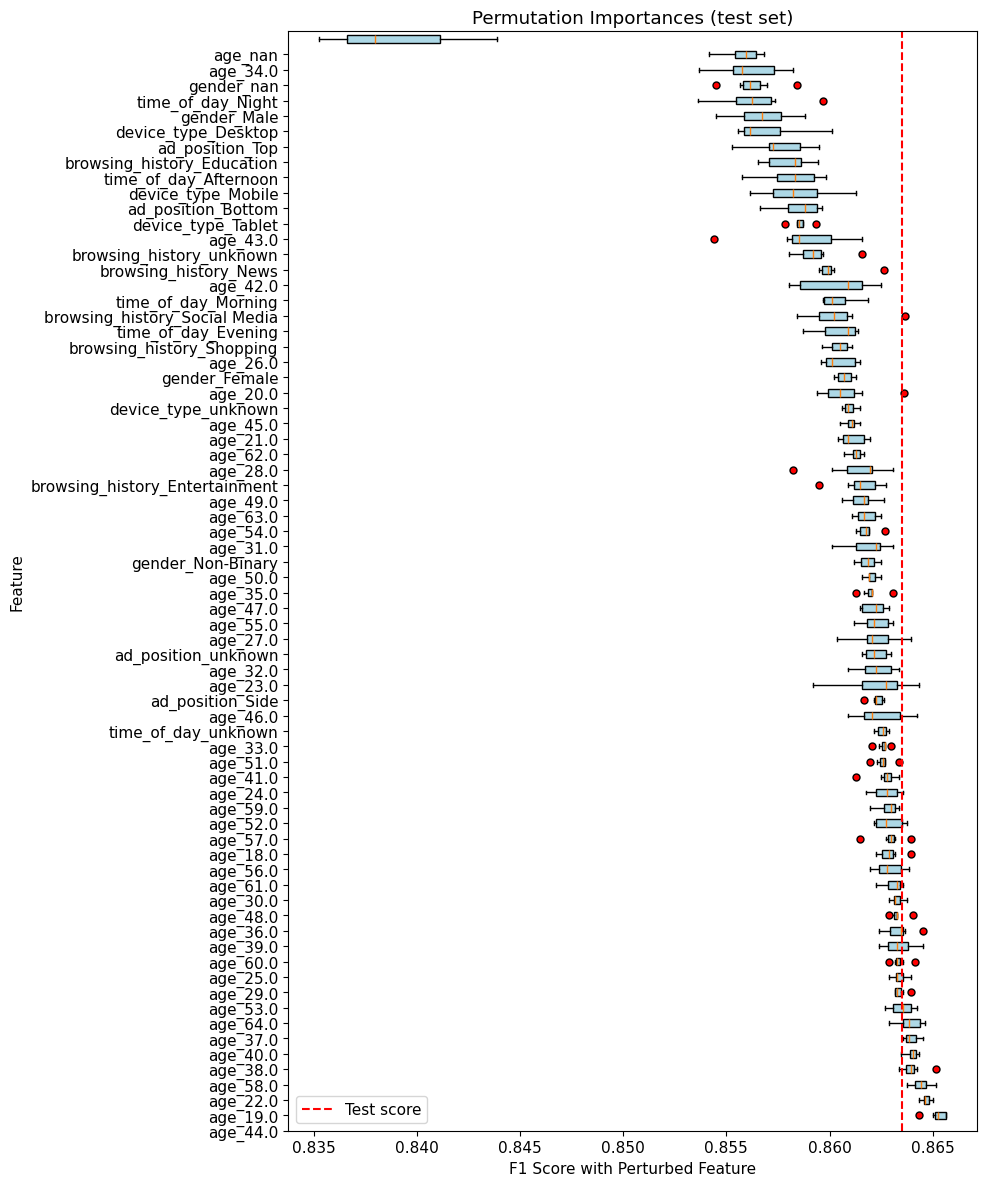

In [6]:
# SVC CV

nr_states = 5
test_scores = np.zeros(nr_states)
final_models = []
val_scores_all_SVC = []
test_scores_all_SVC = []

# loop through the different random states
for i in range(nr_states):
    print('randoms state '+str(i+1))

    # first split to separate out the training set
    X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,random_state=42*i)

    # second split to separate out the validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,random_state=42*i)

    # stratified K fold
    kf = StratifiedKFold(n_splits=4,shuffle=True,random_state=42)
    
    for train_index, val_index in kf.split(X_other,y_other):
        X_train = X_other.iloc[train_index]
        y_train = y_other.iloc[train_index]
        X_val = X_other.iloc[val_index]
        y_val = y_other.iloc[val_index]

    # preprocess the sets
    X_train_prep = prep.fit_transform(X_train)
    X_val_prep = prep.transform(X_val)
    X_test_prep = prep.transform(X_test)

    # hyper parameter tuning
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'gamma': [1e-3, 1e-2, 1e-1, 1, 10],
    }

    train_score = np.zeros(len(ParameterGrid(param_grid)))
    val_score = np.zeros(len(ParameterGrid(param_grid)))
    models = []
    
    # loop through all combinations of hyperparameter combos
    for p in range(len(ParameterGrid(param_grid))):
        params = ParameterGrid(param_grid)[p]
        print('   ',params) 
        clf = SVC(**params, random_state=42) 
        clf.fit(X_train_prep,y_train) # fit the model
        models.append(clf) # save it
        # calculate train and validation accuracy scores
        y_train_pred = clf.predict(X_train_prep)
        train_score[p] = f1_score(y_train,y_train_pred)
        y_val_pred = clf.predict(X_val_prep)
        val_score[p] = f1_score(y_val,y_val_pred)
        print('   ',train_score[p],val_score[p])
    
    # print out model parameters that maximize validation accuracy
    print('best model parameters:',ParameterGrid(param_grid)[np.argmax(val_score)])
    print('corresponding validation score:',np.max(val_score))
    # collect and save the best model
    val_scores_all_SVC.append(np.max(val_score))
    final_models.append(models[np.argmax(val_score)])
    # calculate and save the test score
    y_test_pred = final_models[-1].predict(X_test_prep)
    test_scores[i] = f1_score(y_test,y_test_pred)
    test_scores_all_SVC.append(test_scores[i])
    
    cm = confusion_matrix(y_test,y_test_pred)
    disp = ConfusionMatrixDisplay(cm,display_labels=['class 0', 'class 1'])
    fig, ax = plt.subplots(figsize=(5,3))
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()
    
    print('test score:',test_scores[i])

std_val_score = np.std(val_scores_all_SVC)
std_test_score = np.std(test_scores_all_SVC)
mean_val_score = np.mean(val_scores_all_SVC)
mean_test_score = np.mean(test_scores_all_SVC)

print("mean validation score: ", val_scores_all_SVC)
print("mean test score: ", test_scores_all_SVC)
print("validation standard deviation: ", std_val_score)
print("test standard deviation: ", std_test_score)

ftr_names = preprocessor.named_transformers_['onehot'].get_feature_names_out(input_features=onehot_ftrs)
#feature_names = 
# X after preprocessing

print(ftr_names)

# Number of runs for permutation testing
nr_runs = 7
scores = np.zeros([len(ftr_names), nr_runs])
test_score = np.mean(test_scores_all_SVC)  # mean test score

# Loop through the features
for i in range(len(ftr_names)):
    print(f'Shuffling {ftr_names[i]}')

    # Store the f1 scores for each shuffle run
    f1_scores = []

    for j in range(nr_runs):
        # Create a shuffled copy of the test set with the current feature shuffled
       
        X_test_shuffled = X_test_prep.copy()
        print('X_test_shuffled',X_test_shuffled)
        
        X_test_shuffled[:,i] = np.random.permutation(X_test_prep[:,i])
        
        # Predict with the best model and calculate F1 score
        y_test_pred = final_models[np.argmax(val_scores_all_SVC)].predict(X_test_shuffled)
        f1 = f1_score(y_test, y_test_pred)
        f1_scores.append(f1)

    # Save the f1 scores for this feature
    scores[i] = f1_scores

    # Print the results for this feature
    print(f'   Shuffled test score: {np.mean(f1_scores):.3f} +/- {np.std(f1_scores):.3f}')

# Sort the features by their mean importance scores (descending order)
sorted_indices = np.argsort(np.mean(scores, axis=1))[::-1]

# Set plotting parameters
plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(10, 12))

# Plot a boxplot of feature importances (shuffling results)
plt.boxplot(scores[sorted_indices].T, vert=False, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', color='black'),
            flierprops=dict(markerfacecolor='red', marker='o', markersize=5))

# Plot the test score as a vertical line
plt.axvline(test_score, color='r', linestyle='--', label='Test score')

# Customize the plot
plt.title("Permutation Importances (test set)")
plt.xlabel('F1 Score with Perturbed Feature')
plt.ylabel('Feature')
plt.yticks(ticks=np.arange(len(ftr_names)), labels=np.array(ftr_names)[sorted_indices])

# Add the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [10]:
print("mean validation score: ", np.mean(val_scores_all_SVC))
print("mean test score: ", np.mean(test_scores_all_SVC))

mean validation score:  0.7882855261653353
mean test score:  0.7886591275357526


randoms state 1
    {'n_neighbors': 3}
    0.8602923556194584 0.7447405329593267
    {'n_neighbors': 5}
    0.8365650969529086 0.744345442083619
    {'n_neighbors': 7}
    0.8197975253093364 0.7545393409549428
    {'n_neighbors': 10}
    0.809634089856415 0.7398205659075224
    {'n_neighbors': 15}
    0.7943078913324709 0.763140817650876
    {'n_neighbors': 20}
    0.7919261327034571 0.7699287103046014
best model parameters: {'n_neighbors': 20}
corresponding validation score: 0.7699287103046014


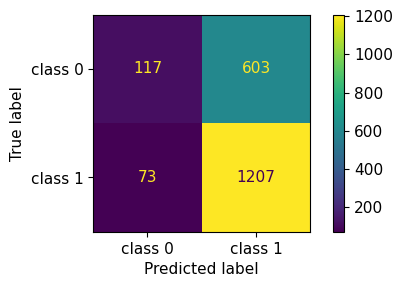

test score: 0.7812297734627832
randoms state 2
    {'n_neighbors': 3}
    0.8628012407539967 0.7433004231311706
    {'n_neighbors': 5}
    0.8343642611683849 0.7619689817936615
    {'n_neighbors': 7}
    0.8176128743853375 0.7675962815405046
    {'n_neighbors': 10}
    0.8053844398813598 0.7471029311520109
    {'n_neighbors': 15}
    0.8018707482993197 0.7708998085513721
    {'n_neighbors': 20}
    0.7945555082943428 0.7669654289372599
best model parameters: {'n_neighbors': 15}
corresponding validation score: 0.7708998085513721


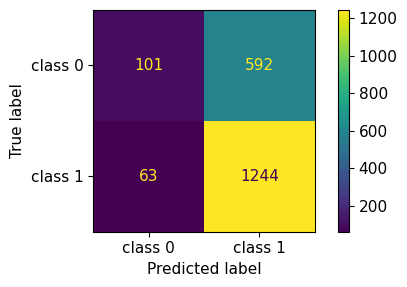

test score: 0.7916003818008273
randoms state 3
    {'n_neighbors': 3}
    0.8534093608933239 0.7510489510489511
    {'n_neighbors': 5}
    0.8293569643262895 0.7667342799188641
    {'n_neighbors': 7}
    0.8158362989323843 0.7661558960692871
    {'n_neighbors': 10}
    0.8034774651109586 0.7537826685006878
    {'n_neighbors': 15}
    0.8008583690987124 0.7766367137355584
    {'n_neighbors': 20}
    0.7959621993127147 0.7741100323624596
best model parameters: {'n_neighbors': 15}
corresponding validation score: 0.7766367137355584


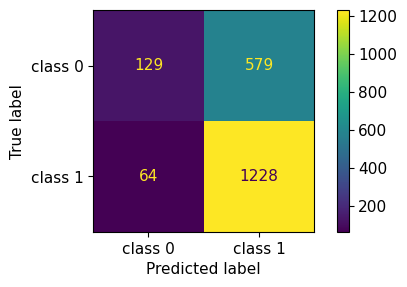

test score: 0.792513714101323
randoms state 4
    {'n_neighbors': 3}
    0.8640730067243035 0.7516014234875444
    {'n_neighbors': 5}
    0.8411560693641619 0.7698686938493434
    {'n_neighbors': 7}
    0.8219800181653043 0.7786774628879892
    {'n_neighbors': 10}
    0.8159963014331947 0.7628294036061026
    {'n_neighbors': 15}
    0.8074588031222897 0.7819354838709678
    {'n_neighbors': 20}
    0.8020901371652515 0.7782101167315175
best model parameters: {'n_neighbors': 15}
corresponding validation score: 0.7819354838709678


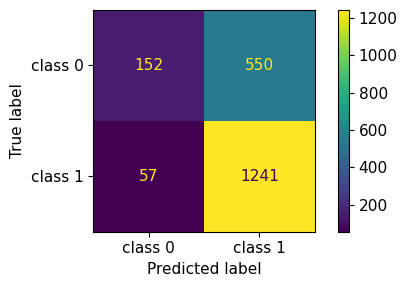

test score: 0.8034962771123341
randoms state 5
    {'n_neighbors': 3}
    0.8614728865735259 0.7649896623018608
    {'n_neighbors': 5}
    0.8325225851285615 0.7650643195666892
    {'n_neighbors': 7}
    0.817687074829932 0.7765176784523016
    {'n_neighbors': 10}
    0.8035014973508409 0.7719537100068073
    {'n_neighbors': 15}
    0.798526863084922 0.7808661926308985
    {'n_neighbors': 20}
    0.7973884657236127 0.7798579728857328
best model parameters: {'n_neighbors': 15}
corresponding validation score: 0.7808661926308985


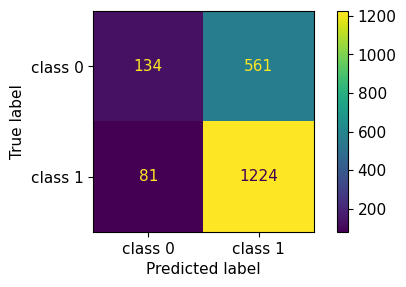

test score: 0.7922330097087379
validation standard deviation:  0.004943146106880944
test standard deviation:  0.007048542043203071
mean val score:  0.7760533818186797
mean test score:  0.792214631237201
['gender_Female' 'gender_Male' 'gender_Non-Binary' 'gender_nan'
 'device_type_Desktop' 'device_type_Mobile' 'device_type_Tablet'
 'device_type_unknown' 'ad_position_Bottom' 'ad_position_Side'
 'ad_position_Top' 'ad_position_unknown' 'browsing_history_Education'
 'browsing_history_Entertainment' 'browsing_history_News'
 'browsing_history_Shopping' 'browsing_history_Social Media'
 'browsing_history_unknown' 'time_of_day_Afternoon' 'time_of_day_Evening'
 'time_of_day_Morning' 'time_of_day_Night' 'time_of_day_unknown'
 'age_18.0' 'age_19.0' 'age_20.0' 'age_21.0' 'age_22.0' 'age_23.0'
 'age_24.0' 'age_25.0' 'age_26.0' 'age_27.0' 'age_28.0' 'age_29.0'
 'age_30.0' 'age_31.0' 'age_32.0' 'age_33.0' 'age_34.0' 'age_35.0'
 'age_36.0' 'age_37.0' 'age_38.0' 'age_39.0' 'age_40.0' 'age_41.0'
 'age_42.

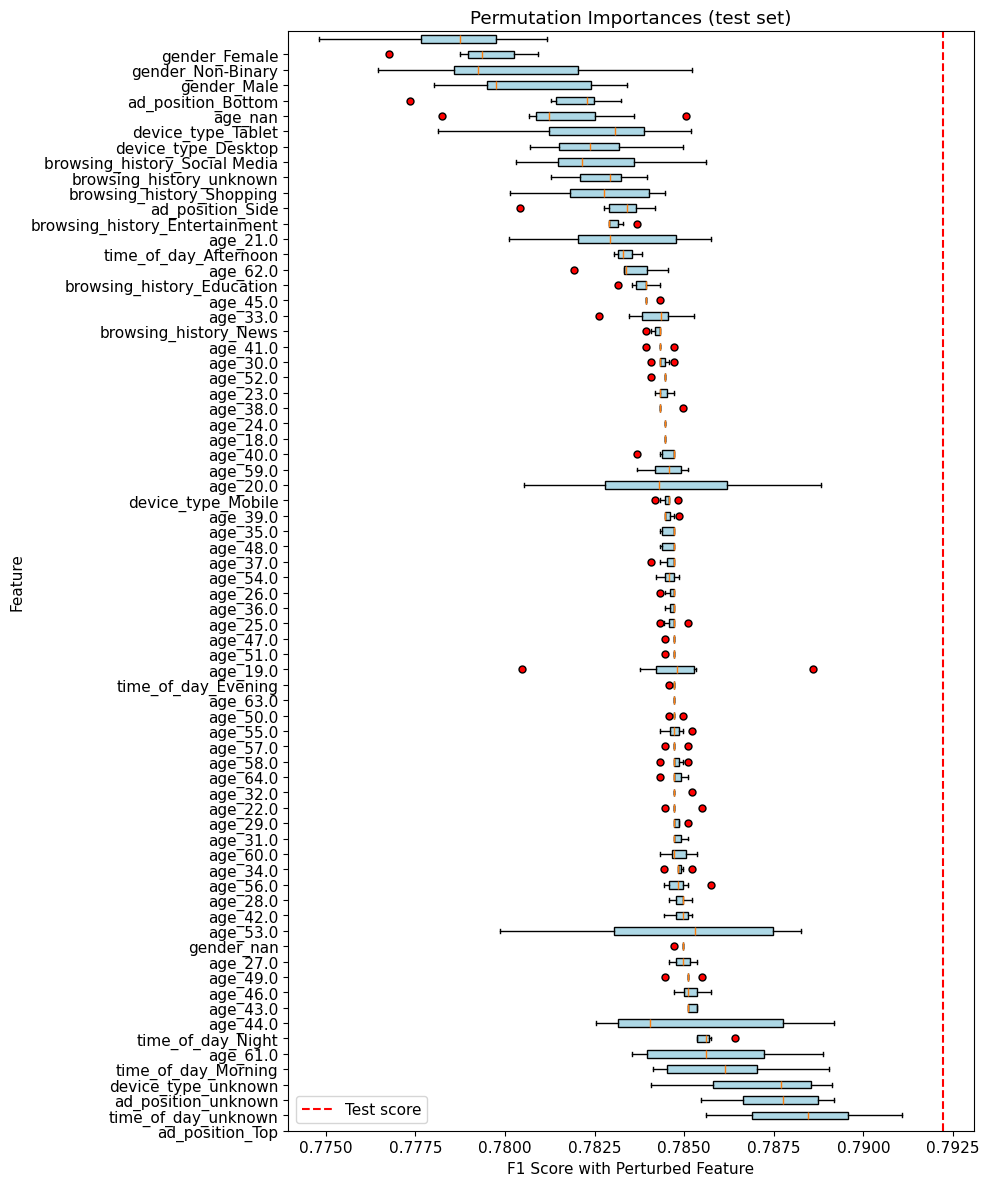

In [42]:
# KNN CV

nr_states = 5
test_scores = np.zeros(nr_states)
final_models = []
val_scores_all_KNN = []
test_scores_all_KNN = []


# loop through the different random states
for i in range(nr_states):
    print('randoms state '+str(i+1))

    # first split to separate out the training set
    X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,random_state=42*i)

    # second split to separate out the validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,random_state=42*i)

    # stratified K fold
    kf = StratifiedKFold(n_splits=4,shuffle=True,random_state=42)
    
    for train_index, val_index in kf.split(X_other,y_other):
        X_train = X_other.iloc[train_index]
        y_train = y_other.iloc[train_index]
        X_val = X_other.iloc[val_index]
        y_val = y_other.iloc[val_index]

    # preprocess the sets
    X_train_prep = prep.fit_transform(X_train)
    X_val_prep = prep.transform(X_val)
    X_test_prep = prep.transform(X_test)

    # hyper parameter tuning
    param_grid = {
        'n_neighbors': [3, 5, 7, 10, 15, 20],        # Number of neighbors to consider
    }

    train_score = np.zeros(len(ParameterGrid(param_grid)))
    val_score = np.zeros(len(ParameterGrid(param_grid)))
    models = []
    
    # loop through all combinations of hyperparameter combos
    for p in range(len(ParameterGrid(param_grid))):
        params = ParameterGrid(param_grid)[p]
        print('   ',params) 
        clf = KNeighborsClassifier(**params)
        clf.fit(X_train_prep,y_train) # fit the model
        models.append(clf) # save it
        # calculate train and validation accuracy scores
        y_train_pred = clf.predict(X_train_prep)
        train_score[p] = f1_score(y_train,y_train_pred)
        y_val_pred = clf.predict(X_val_prep)
        val_score[p] = f1_score(y_val,y_val_pred)
        print('   ',train_score[p],val_score[p])
    
    # print out model parameters that maximize validation accuracy
    print('best model parameters:',ParameterGrid(param_grid)[np.argmax(val_score)])
    print('corresponding validation score:',np.max(val_score))
    # collect and save the best model
    final_models.append(models[np.argmax(val_score)])
    val_scores_all_KNN.append(np.max(val_score))
    
    # calculate and save the test score
    y_test_pred = final_models[-1].predict(X_test_prep)
    test_scores[i] = f1_score(y_test,y_test_pred)
    test_scores_all_KNN.append(test_scores[i])
    cm = confusion_matrix(y_test,y_test_pred)
    disp = ConfusionMatrixDisplay(cm,display_labels=['class 0', 'class 1'])
    fig, ax = plt.subplots(figsize=(5,3))
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()
    print('test score:',test_scores[i])

std_val_score = np.std(val_scores_all_KNN)
std_test_score = np.std(test_scores_all_KNN)
mean_val_score = np.mean(val_scores_all_KNN)
mean_test_score = np.mean(test_scores_all_KNN)
print("validation standard deviation: ", std_val_score)
print("test standard deviation: ", std_test_score)
print("mean val score: ", mean_val_score)
print("mean test score: ", mean_test_score)



ftr_names = preprocessor.named_transformers_['onehot'].get_feature_names_out(input_features=onehot_ftrs)
#feature_names = 
# X after preprocessing

print(ftr_names)

# Number of runs for permutation testing
nr_runs = 7
scores = np.zeros([len(ftr_names), nr_runs])
test_score = np.mean(test_scores_all_KNN)  # mean test score from your KNN models

# Loop through the features
for i in range(len(ftr_names)):
    print(f'Shuffling {ftr_names[i]}')

    # Store the f1 scores for each shuffle run
    f1_scores = []

    for j in range(nr_runs):
        # Create a shuffled copy of the test set with the current feature shuffled
       
        X_test_shuffled = X_test_prep.copy()
        print('X_test_shuffled',X_test_shuffled)
        
        X_test_shuffled[:,i] = np.random.permutation(X_test_prep[:,i])
        
        # Predict with the best model and calculate F1 score
        y_test_pred = final_models[np.argmax(val_scores_all_KNN)].predict(X_test_shuffled)
        f1 = f1_score(y_test, y_test_pred)
        f1_scores.append(f1)

    # Save the f1 scores for this feature
    scores[i] = f1_scores

    # Print the results for this feature
    print(f'   Shuffled test score: {np.mean(f1_scores):.3f} +/- {np.std(f1_scores):.3f}')

# Sort the features by their mean importance scores (descending order)
sorted_indices = np.argsort(np.mean(scores, axis=1))[::-1]

# Set plotting parameters
plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(10, 12))

# Plot a boxplot of feature importances (shuffling results)
plt.boxplot(scores[sorted_indices].T, vert=False, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', color='black'),
            flierprops=dict(markerfacecolor='red', marker='o', markersize=5))

# Plot the test score as a vertical line
plt.axvline(test_score, color='r', linestyle='--', label='Test score')

# Customize the plot
plt.title("Permutation Importances (test set)")
plt.xlabel('F1 Score with Perturbed Feature')
plt.ylabel('Feature')
plt.yticks(ticks=np.arange(len(ftr_names)), labels=np.array(ftr_names)[sorted_indices])

# Add the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

randoms state 1
    {'max_features': 0.25, 'max_depth': 1}
    0.7839481151195784 0.78419452887538
    {'max_features': 0.5, 'max_depth': 1}
    0.7857723577235772 0.7846247712019524
    {'max_features': 0.75, 'max_depth': 1}
    0.7876810116255354 0.7836185819070904
    {'max_features': 1.0, 'max_depth': 1}
    0.7876810116255354 0.7836185819070904
    {'max_features': 0.25, 'max_depth': 3}
    0.7880024484799021 0.7840978593272171
    {'max_features': 0.5, 'max_depth': 3}
    0.7898713498060037 0.7853211009174312
    {'max_features': 0.75, 'max_depth': 3}
    0.7900224902882846 0.7853211009174312
    {'max_features': 1.0, 'max_depth': 3}
    0.7901083180053137 0.784841075794621
    {'max_features': 0.25, 'max_depth': 10}
    0.8039908542922469 0.7876923076923077
    {'max_features': 0.5, 'max_depth': 10}
    0.8088665830196571 0.7891156462585034
    {'max_features': 0.75, 'max_depth': 10}
    0.8078529657477026 0.7898640296662547
    {'max_features': 1.0, 'max_depth': 10}
    0.80768

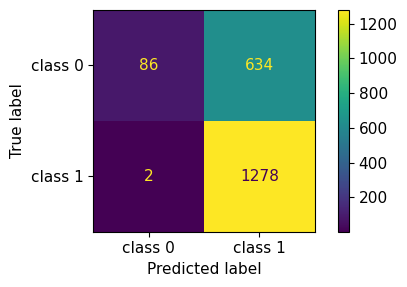

test score: 0.8007518796992481
randoms state 2
    {'max_features': 0.25, 'max_depth': 1}
    0.7900786448880823 0.7893462469733656
    {'max_features': 0.5, 'max_depth': 1}
    0.7925521149564866 0.7910085054678008
    {'max_features': 0.75, 'max_depth': 1}
    0.7947154471544715 0.7921998781230957
    {'max_features': 1.0, 'max_depth': 1}
    0.7947154471544715 0.7921998781230957
    {'max_features': 0.25, 'max_depth': 3}
    0.7954499289051391 0.7929354445797807
    {'max_features': 0.5, 'max_depth': 3}
    0.7952052011377488 0.7929354445797807
    {'max_features': 0.75, 'max_depth': 3}
    0.7952052011377488 0.7929354445797807
    {'max_features': 1.0, 'max_depth': 3}
    0.7954499289051391 0.7929354445797807
    {'max_features': 0.25, 'max_depth': 10}
    0.8088356729975227 0.7945879458794588
    {'max_features': 0.5, 'max_depth': 10}
    0.8111801242236025 0.7958050586057989
    {'max_features': 0.75, 'max_depth': 10}
    0.8105088953247828 0.7953144266337855
    {'max_features':

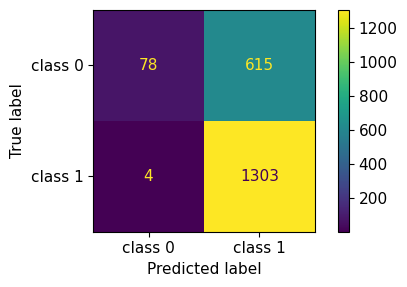

test score: 0.808062015503876
randoms state 3
    {'max_features': 0.25, 'max_depth': 1}
    0.7868985038414881 0.7871437234687689
    {'max_features': 0.5, 'max_depth': 1}
    0.7891211690683986 0.7866261398176292
    {'max_features': 0.75, 'max_depth': 1}
    0.7891211690683986 0.7866261398176292
    {'max_features': 1.0, 'max_depth': 1}
    0.7891211690683986 0.7866261398176292
    {'max_features': 0.25, 'max_depth': 3}
    0.7925835370823145 0.7863664029214851
    {'max_features': 0.5, 'max_depth': 3}
    0.7933074882677005 0.7863247863247863
    {'max_features': 0.75, 'max_depth': 3}
    0.7930612244897959 0.7855833842394624
    {'max_features': 1.0, 'max_depth': 3}
    0.7930612244897959 0.7855833842394624
    {'max_features': 0.25, 'max_depth': 10}
    0.8098210570120683 0.7904118008604795
    {'max_features': 0.5, 'max_depth': 10}
    0.8104956268221575 0.7918468190240889
    {'max_features': 0.75, 'max_depth': 10}
    0.8116002503651157 0.7911001236093943
    {'max_features': 

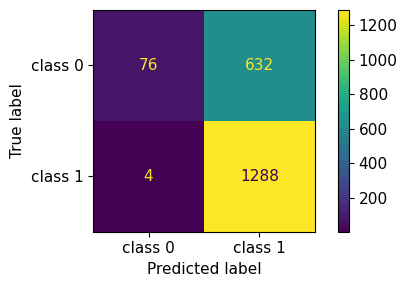

test score: 0.8019925280199253
randoms state 4
    {'max_features': 0.25, 'max_depth': 1}
    0.7868985038414881 0.7864077669902912
    {'max_features': 0.5, 'max_depth': 1}
    0.7884810383289393 0.7882855399633923
    {'max_features': 0.75, 'max_depth': 1}
    0.7884810383289393 0.7882855399633923
    {'max_features': 1.0, 'max_depth': 1}
    0.7884810383289393 0.7882855399633923
    {'max_features': 0.25, 'max_depth': 3}
    0.7899330221229958 0.7897310513447433
    {'max_features': 0.5, 'max_depth': 3}
    0.790253807106599 0.7906976744186046
    {'max_features': 0.75, 'max_depth': 3}
    0.7901685963843185 0.7916666666666666
    {'max_features': 1.0, 'max_depth': 3}
    0.7900081234768481 0.7906976744186046
    {'max_features': 0.25, 'max_depth': 10}
    0.8094841930116472 0.7962962962962963
    {'max_features': 0.5, 'max_depth': 10}
    0.8154524459374344 0.7980173482032218
    {'max_features': 0.75, 'max_depth': 10}
    0.8180286436394272 0.7975232198142415
    {'max_features': 

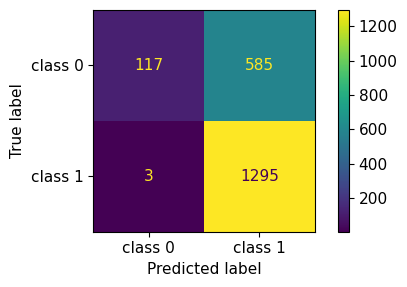

test score: 0.8149779735682819
randoms state 5
    {'max_features': 0.25, 'max_depth': 1}
    0.7895904781117612 0.7893462469733656
    {'max_features': 0.5, 'max_depth': 1}
    0.7895904781117612 0.7893462469733656
    {'max_features': 0.75, 'max_depth': 1}
    0.7895904781117612 0.7893462469733656
    {'max_features': 1.0, 'max_depth': 1}
    0.7910931174089069 0.7888349514563107
    {'max_features': 0.25, 'max_depth': 3}
    0.7933482052322044 0.7924528301886793
    {'max_features': 0.5, 'max_depth': 3}
    0.795116988809766 0.7943868212324589
    {'max_features': 0.75, 'max_depth': 3}
    0.7948717948717948 0.7948717948717948
    {'max_features': 1.0, 'max_depth': 3}
    0.795116988809766 0.793398533007335
    {'max_features': 0.25, 'max_depth': 10}
    0.8133056133056134 0.8002481389578163
    {'max_features': 0.5, 'max_depth': 10}
    0.8138131890992303 0.8014888337468983
    {'max_features': 0.75, 'max_depth': 10}
    0.8139825218476904 0.8024844720496894
    {'max_features': 1.

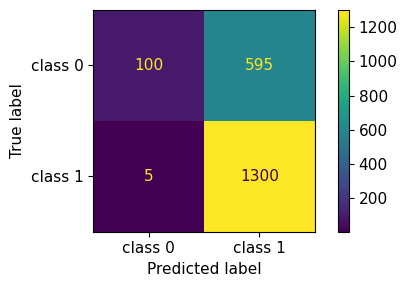

test score: 0.8125
validation standard deviation:  0.004642152242055039
test standard deviation:  0.00560325386992234
mean val score:  0.7958023384857468
mean test score:  0.8076568793582662
['gender_Female' 'gender_Male' 'gender_Non-Binary' 'gender_nan'
 'device_type_Desktop' 'device_type_Mobile' 'device_type_Tablet'
 'device_type_unknown' 'ad_position_Bottom' 'ad_position_Side'
 'ad_position_Top' 'ad_position_unknown' 'browsing_history_Education'
 'browsing_history_Entertainment' 'browsing_history_News'
 'browsing_history_Shopping' 'browsing_history_Social Media'
 'browsing_history_unknown' 'time_of_day_Afternoon' 'time_of_day_Evening'
 'time_of_day_Morning' 'time_of_day_Night' 'time_of_day_unknown'
 'age_18.0' 'age_19.0' 'age_20.0' 'age_21.0' 'age_22.0' 'age_23.0'
 'age_24.0' 'age_25.0' 'age_26.0' 'age_27.0' 'age_28.0' 'age_29.0'
 'age_30.0' 'age_31.0' 'age_32.0' 'age_33.0' 'age_34.0' 'age_35.0'
 'age_36.0' 'age_37.0' 'age_38.0' 'age_39.0' 'age_40.0' 'age_41.0'
 'age_42.0' 'age_43.0

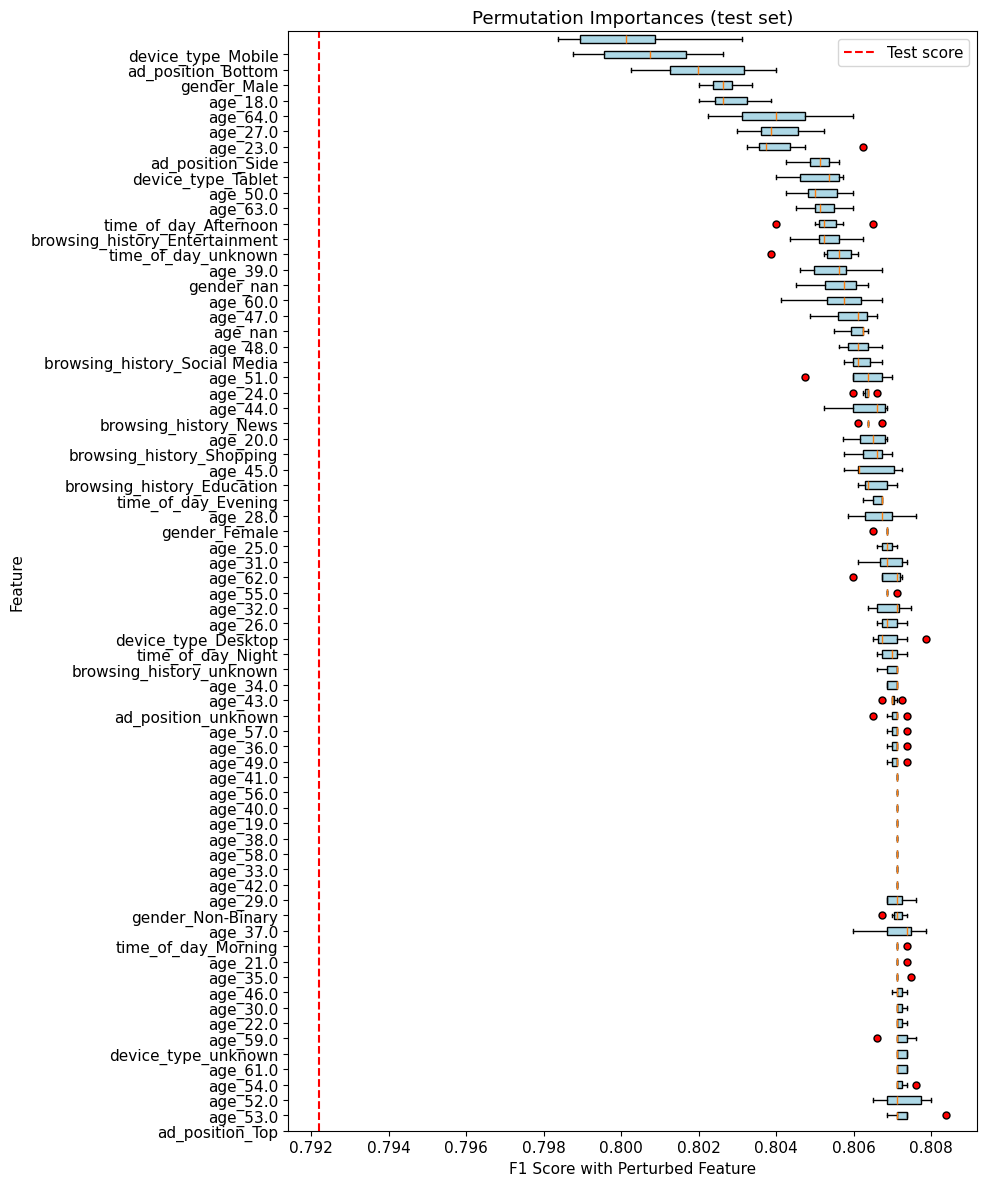

In [43]:
# Random Forest CV

nr_states = 5
test_scores = np.zeros(nr_states)
final_models = []
val_scores_all_RFC = []
test_scores_all_RFC = []

# loop through the different random states
for i in range(nr_states):
    print('randoms state '+str(i+1))

    # first split to separate out the training set
    X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,random_state=42*i)

    # second split to separate out the validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,random_state=42*i)

    # stratified K fold
    kf = StratifiedKFold(n_splits=4,shuffle=True,random_state=42)
    
    for train_index, val_index in kf.split(X_other,y_other):
        X_train = X_other.iloc[train_index]
        y_train = y_other.iloc[train_index]
        X_val = X_other.iloc[val_index]
        y_val = y_other.iloc[val_index]

    # preprocess the sets
    X_train_prep = prep.fit_transform(X_train)
    X_val_prep = prep.transform(X_val)
    X_test_prep = prep.transform(X_test)

    # hyper parameter tuning
    param_grid = {
                  'max_depth': [1, 3, 10, 30, 100], # no upper bound so the values are evenly spaced in log
                  'max_features': [0.25, 0.5,0.75,1.0] # linearly spaced because it is between 0 and 1, 0 is omitted
                  }

    train_score = np.zeros(len(ParameterGrid(param_grid)))
    val_score = np.zeros(len(ParameterGrid(param_grid)))
    models = []
    
    # loop through all combinations of hyperparameter combos
    for p in range(len(ParameterGrid(param_grid))):
        params = ParameterGrid(param_grid)[p]
        print('   ',params) 
        clf = RandomForestClassifier(**params,random_state = 42*i,n_jobs=-1) # initialize the classifier
        clf.fit(X_train_prep,y_train) # fit the model
         
        models.append(clf) # save it
        # calculate train and validation accuracy scores
        y_train_pred = clf.predict(X_train_prep)
        train_score[p] = f1_score(y_train,y_train_pred)
        y_val_pred = clf.predict(X_val_prep)
        val_score[p] = f1_score(y_val,y_val_pred)
        print('   ',train_score[p],val_score[p])
    
    # print out model parameters that maximize validation accuracy
    print('best model parameters:',ParameterGrid(param_grid)[np.argmax(val_score)])
    print('corresponding validation score:',np.max(val_score))
    # collect and save the best model
    final_models.append(models[np.argmax(val_score)])
    val_scores_all_RFC.append(np.max(val_score))
    
    # calculate and save the test score
    y_test_pred = final_models[-1].predict(X_test_prep)
    test_scores[i] = f1_score(y_test,y_test_pred)
    test_scores_all_RFC.append(test_scores[i])
    
    cm = confusion_matrix(y_test,y_test_pred)
    disp = ConfusionMatrixDisplay(cm,display_labels=['class 0', 'class 1'])
    fig, ax = plt.subplots(figsize=(5,3))
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()
    
    print('test score:',test_scores[i])

std_val_score = np.std(val_scores_all_RFC)
std_test_score = np.std(test_scores_all_RFC)
mean_val_score = np.mean(val_scores_all_RFC)
mean_test_score = np.mean(test_scores_all_RFC)

print("validation standard deviation: ", std_val_score)
print("test standard deviation: ", std_test_score)
print("mean val score: ", mean_val_score)
print("mean test score: ", mean_test_score)


ftr_names = preprocessor.named_transformers_['onehot'].get_feature_names_out(input_features=onehot_ftrs)
#feature_names = 
# X after preprocessing

print(ftr_names)

# Number of runs for permutation testing
nr_runs = 7
scores = np.zeros([len(ftr_names), nr_runs])
test_score = np.mean(test_scores_all_KNN)  # mean test score from your KNN models

# Loop through the features
for i in range(len(ftr_names)):
    print(f'Shuffling {ftr_names[i]}')

    # Store the f1 scores for each shuffle run
    f1_scores = []

    for j in range(nr_runs):
        # Create a shuffled copy of the test set with the current feature shuffled
       
        X_test_shuffled = X_test_prep.copy()
        print('X_test_shuffled',X_test_shuffled)
        
        X_test_shuffled[:,i] = np.random.permutation(X_test_prep[:,i])
        
        # Predict with the best model and calculate F1 score
        y_test_pred = final_models[np.argmax(val_scores_all_KNN)].predict(X_test_shuffled)
        f1 = f1_score(y_test, y_test_pred)
        f1_scores.append(f1)

    # Save the f1 scores for this feature
    scores[i] = f1_scores

    # Print the results for this feature
    print(f'   Shuffled test score: {np.mean(f1_scores):.3f} +/- {np.std(f1_scores):.3f}')

# Sort the features by their mean importance scores (descending order)
sorted_indices = np.argsort(np.mean(scores, axis=1))[::-1]

# Set plotting parameters
plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(10, 12))

# Plot a boxplot of feature importances (shuffling results)
plt.boxplot(scores[sorted_indices].T, vert=False, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', color='black'),
            flierprops=dict(markerfacecolor='red', marker='o', markersize=5))

# Plot the test score as a vertical line
plt.axvline(test_score, color='r', linestyle='--', label='Test score')

# Customize the plot
plt.title("Permutation Importances (test set)")
plt.xlabel('F1 Score with Perturbed Feature')
plt.ylabel('Feature')
plt.yticks(ticks=np.arange(len(ftr_names)), labels=np.array(ftr_names)[sorted_indices])

# Add the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

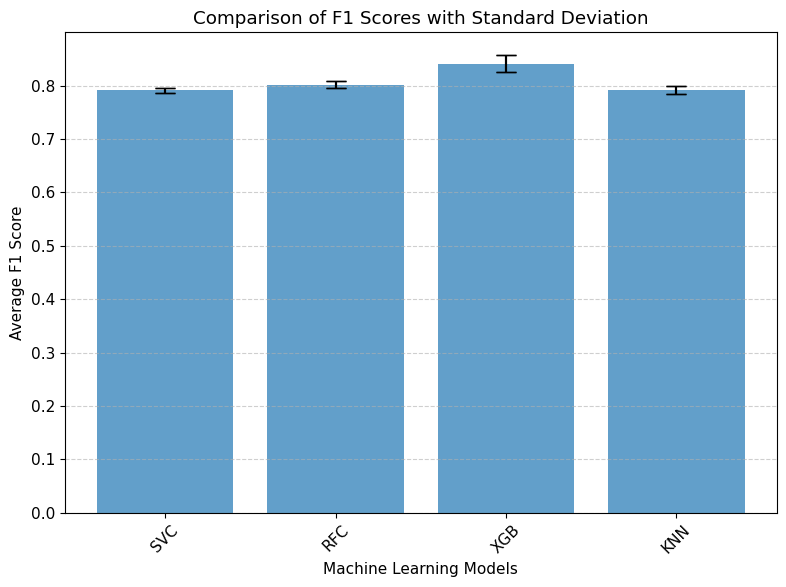

In [11]:

# Define model names and their corresponding average F1 scores and standard deviations

models = ["SVC", "RFC", "XGB", "KNN"]
avg_f1_scores = [0.791, 0.802, 0.841, 0.792]
std_dev = [0.005, 0.006, 0.016, 0.007]



# Create a bar plot with error bars
plt.figure(figsize=(8, 6))
plt.bar(models, avg_f1_scores, yerr=std_dev, capsize=7, alpha=0.7)

# Set labels and title
plt.xlabel("Machine Learning Models")
plt.ylabel("Average F1 Score")
plt.title("Comparison of F1 Scores with Standard Deviation")

# Add error bars to the plot
plt.errorbar(models, avg_f1_scores, yerr=std_dev, fmt='none', ecolor='black', capsize=7)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


randoms state 1
    {'subsample': 0.66, 'seed': 0, 'reg_lambda': 0.0, 'reg_alpha': 0.0, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
    0.7894736842105263 0.7839009287925697
    {'subsample': 0.66, 'seed': 0, 'reg_lambda': 0.01, 'reg_alpha': 0.0, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
    0.7894736842105263 0.7839009287925697
    {'subsample': 0.66, 'seed': 0, 'reg_lambda': 0.1, 'reg_alpha': 0.0, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
    0.7898115551874094 0.7839009287925697
    {'subsample': 0.66, 'seed': 0, 'reg_lambda': 0.0, 'reg_alpha': 0.01, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
    0.7894736842105263 0.7839009287925697
    {'subsample': 0.66, 'seed': 0, 'reg_lambda': 0.01, 'reg_alpha': 0.01, 'n_estimators': 10000, 'missing': nan, '

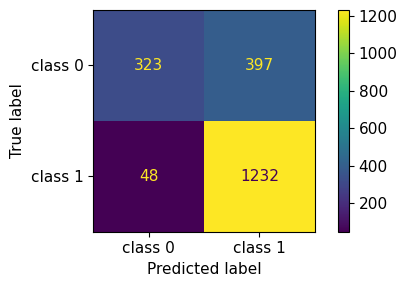

test score: 0.8470264695771743
randoms state 2
    {'subsample': 0.66, 'seed': 0, 'reg_lambda': 0.0, 'reg_alpha': 0.0, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
    0.7965819091288037 0.783427495291902
    {'subsample': 0.66, 'seed': 0, 'reg_lambda': 0.01, 'reg_alpha': 0.0, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
    0.7964159199833298 0.7841907151819323
    {'subsample': 0.66, 'seed': 0, 'reg_lambda': 0.1, 'reg_alpha': 0.0, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
    0.7959183673469388 0.7882573391630231
    {'subsample': 0.66, 'seed': 0, 'reg_lambda': 0.0, 'reg_alpha': 0.01, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
    0.7964159199833298 0.7849529780564264
    {'subsample': 0.66, 'seed': 0, 'reg_lambda': 0.01, 'reg_alpha': 0.01, 'n_estimat

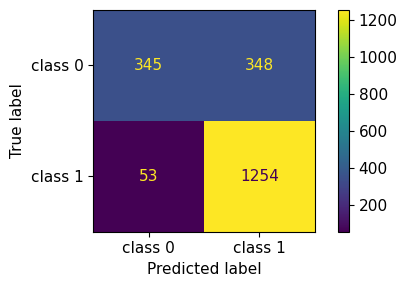

test score: 0.8621519422481952
randoms state 3
    {'subsample': 0.66, 'seed': 0, 'reg_lambda': 0.0, 'reg_alpha': 0.0, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
    0.7896019496344435 0.7866261398176292
    {'subsample': 0.66, 'seed': 0, 'reg_lambda': 0.01, 'reg_alpha': 0.0, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
    0.7896019496344435 0.7866261398176292
    {'subsample': 0.66, 'seed': 0, 'reg_lambda': 0.1, 'reg_alpha': 0.0, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
    0.7896019496344435 0.7866261398176292
    {'subsample': 0.66, 'seed': 0, 'reg_lambda': 0.0, 'reg_alpha': 0.01, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
    0.7896019496344435 0.7866261398176292
    {'subsample': 0.66, 'seed': 0, 'reg_lambda': 0.01, 'reg_alpha': 0.01, 'n_estima

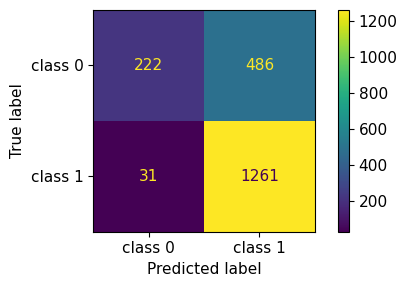

test score: 0.8298782494241527
randoms state 4
    {'subsample': 0.66, 'seed': 0, 'reg_lambda': 0.0, 'reg_alpha': 0.0, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
    0.7948932607785685 0.7844611528822055
    {'subsample': 0.66, 'seed': 0, 'reg_lambda': 0.01, 'reg_alpha': 0.0, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
    0.7948932607785685 0.7844611528822055
    {'subsample': 0.66, 'seed': 0, 'reg_lambda': 0.1, 'reg_alpha': 0.0, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
    0.7914262159934048 0.7863777089783281
    {'subsample': 0.66, 'seed': 0, 'reg_lambda': 0.0, 'reg_alpha': 0.01, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
    0.7911588514769675 0.78735275883447
    {'subsample': 0.66, 'seed': 0, 'reg_lambda': 0.01, 'reg_alpha': 0.01, 'n_estimato

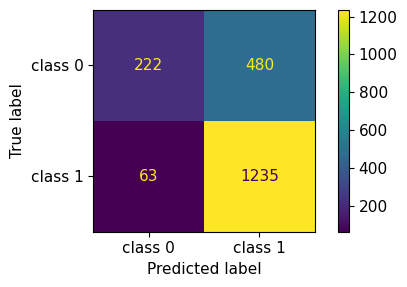

test score: 0.8197809492200465
randoms state 5
    {'subsample': 0.66, 'seed': 0, 'reg_lambda': 0.0, 'reg_alpha': 0.0, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
    0.7966666666666666 0.793988728866625
    {'subsample': 0.66, 'seed': 0, 'reg_lambda': 0.01, 'reg_alpha': 0.0, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
    0.7966666666666666 0.793988728866625
    {'subsample': 0.66, 'seed': 0, 'reg_lambda': 0.1, 'reg_alpha': 0.0, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
    0.7967513536026656 0.793730407523511
    {'subsample': 0.66, 'seed': 0, 'reg_lambda': 0.0, 'reg_alpha': 0.01, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
    0.7966666666666666 0.793988728866625
    {'subsample': 0.66, 'seed': 0, 'reg_lambda': 0.01, 'reg_alpha': 0.01, 'n_estimators

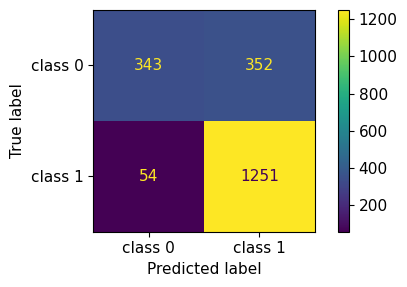

test score: 0.8603851444291609
validation standard deviation:  0.004641552625865528
test standard deviation:  0.016691260716115847
mean val score:  0.7946448178040533
mean test score:  0.8438445509797459
['gender_Female' 'gender_Male' 'gender_Non-Binary' 'gender_nan'
 'device_type_Desktop' 'device_type_Mobile' 'device_type_Tablet'
 'device_type_unknown' 'ad_position_Bottom' 'ad_position_Side'
 'ad_position_Top' 'ad_position_unknown' 'browsing_history_Education'
 'browsing_history_Entertainment' 'browsing_history_News'
 'browsing_history_Shopping' 'browsing_history_Social Media'
 'browsing_history_unknown' 'time_of_day_Afternoon' 'time_of_day_Evening'
 'time_of_day_Morning' 'time_of_day_Night' 'time_of_day_unknown'
 'age_18.0' 'age_19.0' 'age_20.0' 'age_21.0' 'age_22.0' 'age_23.0'
 'age_24.0' 'age_25.0' 'age_26.0' 'age_27.0' 'age_28.0' 'age_29.0'
 'age_30.0' 'age_31.0' 'age_32.0' 'age_33.0' 'age_34.0' 'age_35.0'
 'age_36.0' 'age_37.0' 'age_38.0' 'age_39.0' 'age_40.0' 'age_41.0'
 'age_42

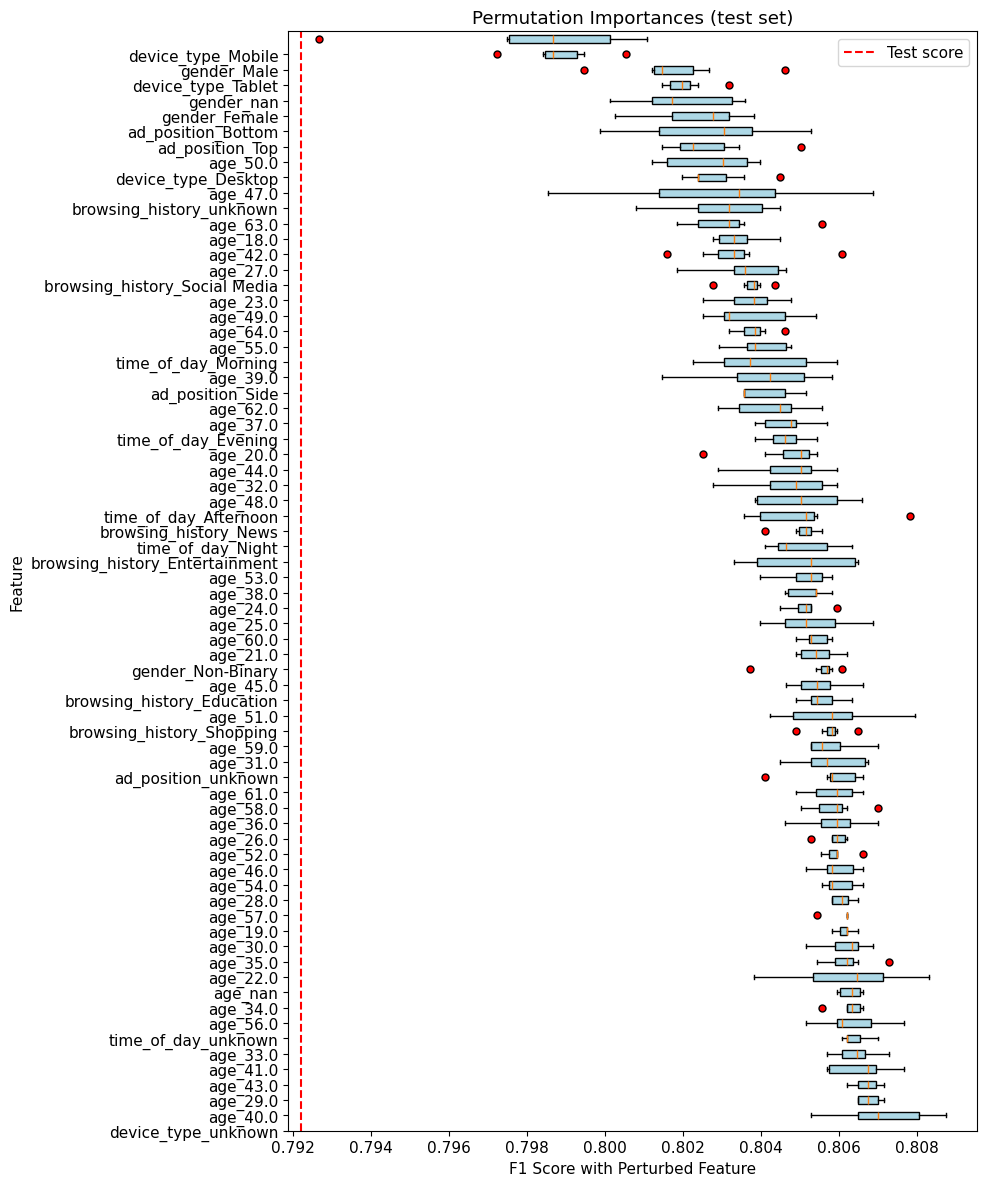

In [45]:
# XGBoost CV

nr_states = 5
test_scores = np.zeros(nr_states)
final_models = []
val_scores_all_XGB = []
test_scores_all_XGB = []

# loop through the different random states
for i in range(nr_states):
    print('randoms state '+str(i+1))

    # first split to separate out the training set
    X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,random_state=42*i)

    # second split to separate out the validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,random_state=42*i)

    for train_index, val_index in kf.split(X_other,y_other):
        X_train = X_other.iloc[train_index]
        y_train = y_other.iloc[train_index]
        X_val = X_other.iloc[val_index]
        y_val = y_other.iloc[val_index]

    
    # preprocess the sets
    X_train_prep = prep.fit_transform(X_train)
    X_val_prep = prep.transform(X_val)
    X_test_prep = prep.transform(X_test)

    # hyper parameter tuning
    param_grid = {"learning_rate": [0.03],
                  "n_estimators": [10000],
                  "seed": [0],
                  "reg_alpha": [0e0, 1e-2, 1e-1],
                  "reg_lambda": [0e0, 1e-2, 1e-1],
                  "missing": [np.nan], 
                  "max_depth": [1,3,10,30,50],
                  "colsample_bytree": [0.9],              
                  "subsample": [0.66]}

    train_score = np.zeros(len(ParameterGrid(param_grid)))
    val_score = np.zeros(len(ParameterGrid(param_grid)))
    models = []
    
    # loop through all combinations of hyperparameter combos
    for p in range(len(ParameterGrid(param_grid))):
        params = ParameterGrid(param_grid)[p]
        print('   ',params)  
        clf = XGBClassifier(**params, random_state=42 * i, n_jobs=-1, early_stopping_rounds=50) # initialize the classifier
        eval_set = [(X_val_prep, y_val)]  # List of tuples with validation data 
        clf.fit(X_train_prep,y_train, eval_set=eval_set, verbose=False) # fit the model        
        models.append(clf) # save it
        # calculate train and validation accuracy scores
        y_train_pred = clf.predict(X_train_prep)
        train_score[p] = f1_score(y_train,y_train_pred)
        y_val_pred = clf.predict(X_val_prep)
        val_score[p] = f1_score(y_val,y_val_pred)
        print('   ',train_score[p],val_score[p])
    
    # print out model parameters that maximize validation accuracy
    print('best model parameters:',ParameterGrid(param_grid)[np.argmax(val_score)])
    print('corresponding validation score:',np.max(val_score))
    # collect and save the best model
    final_models.append(models[np.argmax(val_score)])
    val_scores_all_XGB.append(np.max(val_score))

    # calculate and save the test score
    y_test_pred = final_models[-1].predict(X_test_prep)
    test_scores[i] = f1_score(y_test,y_test_pred)
    test_scores_all_XGB.append(test_scores[i])

    cm = confusion_matrix(y_test,y_test_pred)
    disp = ConfusionMatrixDisplay(cm,display_labels=['class 0', 'class 1'])
    fig, ax = plt.subplots(figsize=(5,3))
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()
    print('test score:',test_scores[i])

std_val_score = np.std(val_scores_all_XGB)
std_test_score = np.std(test_scores_all_XGB)
mean_val_score = np.mean(val_scores_all_XGB)
mean_test_score = np.mean(test_scores_all_XGB)

print("validation standard deviation: ", std_val_score)
print("test standard deviation: ", std_test_score)
print("mean val score: ", mean_val_score)
print("mean test score: ", mean_test_score)

ftr_names = preprocessor.named_transformers_['onehot'].get_feature_names_out(input_features=onehot_ftrs)
#feature_names = 
# X after preprocessing

print(ftr_names)

# Number of runs for permutation testing
nr_runs = 7
scores = np.zeros([len(ftr_names), nr_runs])
test_score = np.mean(test_scores_all_KNN)  # mean test score from your KNN models

# Loop through the features
for i in range(len(ftr_names)):
    print(f'Shuffling {ftr_names[i]}')

    # Store the f1 scores for each shuffle run
    f1_scores = []

    for j in range(nr_runs):
        # Create a shuffled copy of the test set with the current feature shuffled
       
        X_test_shuffled = X_test_prep.copy()
        print('X_test_shuffled',X_test_shuffled)
        
        X_test_shuffled[:,i] = np.random.permutation(X_test_prep[:,i])
        
        # Predict with the best model and calculate F1 score
        y_test_pred = final_models[np.argmax(val_scores_all_KNN)].predict(X_test_shuffled)
        f1 = f1_score(y_test, y_test_pred)
        f1_scores.append(f1)

    # Save the f1 scores for this feature
    scores[i] = f1_scores

    # Print the results for this feature
    print(f'   Shuffled test score: {np.mean(f1_scores):.3f} +/- {np.std(f1_scores):.3f}')

# Sort the features by their mean importance scores (descending order)
sorted_indices = np.argsort(np.mean(scores, axis=1))[::-1]

# Set plotting parameters
plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(10, 12))

# Plot a boxplot of feature importances (shuffling results)
plt.boxplot(scores[sorted_indices].T, vert=False, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', color='black'),
            flierprops=dict(markerfacecolor='red', marker='o', markersize=5))

# Plot the test score as a vertical line
plt.axvline(test_score, color='r', linestyle='--', label='Test score')

# Customize the plot
plt.title("Permutation Importances (test set)")
plt.xlabel('F1 Score with Perturbed Feature')
plt.ylabel('Feature')
plt.yticks(ticks=np.arange(len(ftr_names)), labels=np.array(ftr_names)[sorted_indices])

# Add the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()